In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))


%load_ext autoreload
%autoreload 2

/home/octav/gitrepos/tum-thesis


In [93]:
from otgnn.models import GCN
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty

from rdkit.Chem import MolFromSmiles

import torch
import numpy as np
import time

In [94]:
sys.argv = ["", "-cuda"]
args = get_args()

In [95]:
model = "transformer3"
args.output_dir = f"mol_opt/output_{model}/"
model_iter = 18 

model_name = "model_{}_{}".format(model, model_iter)
model_decode_name = "model_{}_decode_{}".format(model, model_iter)
molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
molopt, config

(MolOpt(
   (GCN): GCN(
     (W_message_i): Linear(in_features=100, out_features=50, bias=False)
     (W_message_h): Linear(in_features=50, out_features=50, bias=False)
     (W_message_o): Linear(in_features=143, out_features=50, bias=True)
     (W_mol_h): Linear(in_features=50, out_features=100, bias=True)
     (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
     (dropout_gcn): Dropout(p=0.0, inplace=False)
     (dropout_ffn): Dropout(p=0.0, inplace=False)
   )
   (opt0): Linear(in_features=50, out_features=50, bias=True)
   (opt1): Linear(in_features=50, out_features=50, bias=True)
   (transformer): Encoder(
     (layers): ModuleList(
       (0): EncoderLayer(
         (self_attn): MultiHeadedAttention(
           (linears): ModuleList(
             (0): Linear(in_features=50, out_features=50, bias=True)
             (1): Linear(in_features=50, out_features=50, bias=True)
             (2): Linear(in_features=50, out_features=50, bias=True)
             (3): Linear(in_fe

In [96]:
molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
molopt_decoder, config_decoder

(MolOptDecoder(
   (fc1_SYMBOLS): Linear(in_features=50, out_features=150, bias=True)
   (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
   (fc1_CHARGES): Linear(in_features=50, out_features=150, bias=True)
   (fc2_CHARGES): Linear(in_features=150, out_features=5, bias=True)
   (fc1_BONDS): Linear(in_features=100, out_features=150, bias=True)
   (fc2_BONDS): Linear(in_features=150, out_features=5, bias=True)
 ),
 Namespace(N_transformer=6, agg_func='sum', annealing_rate=0.05, batch_norm=False, connectivity=True, connectivity_hard=False, connectivity_lambda=0.015, cuda=True, device='cuda:0', dim_tangent_space=40, dropout_ffn=0.0, dropout_gcn=0.0, dropout_transformer=0.1, euler_characteristic_penalty=True, euler_lambda=0.2, ffn_activation='LeakyReLU', init_decoder_model='transformer3_decode', init_model='transformer3', linear_out=False, n_epochs=40, n_ffn_hidden=100, n_ffn_transformer=100, n_heads_transformer=10, n_hidden=50, n_labels=1, n_layers=5, ot_solver='emd', ou

In [97]:
train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train", 36, False)
val_data_loader = get_loader("iclr19-graph2graph/data/qed", "val", 36, False)

In [98]:
for i in val_data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

# Assess GCN

In [99]:
x_embedding, x_delta_hat = molopt.forward(X)
y_embedding = molopt.encode(Y)

In [100]:
x_embedding + x_delta_hat

tensor([[  2690.6057,   1767.2057,    171.0964,  ...,   -407.0964,
           -377.2776,  -1971.5316],
        [ -4133.7656,   8482.5889,   -958.6725,  ...,  -6789.9404,
           -962.8101,  -7868.5879],
        [ -8562.2480,  12347.3750,  -1755.6935,  ..., -10416.3809,
          -1202.2391, -10941.0879],
        ...,
        [ -2958.4758,   4196.1831,   -925.5811,  ...,  -4383.8716,
           -232.8312,  -2531.4536],
        [   587.8792,    798.2252,     50.2693,  ...,   -567.6630,
           -103.6006,   -756.1357],
        [  2128.0601,   1661.7357,   -106.9365,  ...,   -713.1708,
           -165.3434,  -1352.5715]], device='cuda:0', grad_fn=<AddBackward0>)

In [101]:
y_embedding

tensor([[-1928.9287,  4200.1392,  -512.3777,  ..., -3289.8823,  -546.1613,
         -3521.1797],
        [-2674.5303,  5175.5024, -1090.1897,  ..., -4984.7437,  -281.4836,
         -2986.0088],
        [-3643.7222,  7885.5933,  -866.8009,  ..., -6231.6182,  -909.9247,
         -7332.1577],
        ...,
        [-4706.2944,  6654.4438,  -956.1565,  ..., -5800.4443,  -625.9386,
         -5812.1792],
        [   88.0429,   300.2886,    -8.5828,  ...,  -260.5809,   -18.6943,
          -230.1924],
        [ 2918.2695,  1319.2074,   211.9501,  ...,   189.7196,  -401.2389,
         -1725.1124]], device='cuda:0', grad_fn=<CopySlices>)

In [102]:
x_embedding

tensor([[  2689.2769,   1768.2946,    171.9630,  ...,   -403.0281,
           -377.3643,  -1970.5835],
        [ -4136.8989,   8483.1553,   -958.0532,  ...,  -6785.6479,
           -963.0444,  -7867.6533],
        [ -8562.8252,  12347.9492,  -1754.9928,  ..., -10412.2363,
          -1202.6572, -10940.1865],
        ...,
        [ -2959.1479,   4196.7456,   -924.7463,  ...,  -4379.6216,
           -232.9506,  -2530.5833],
        [   584.4029,    798.7108,     51.3827,  ...,   -568.0923,
           -103.2568,   -755.1224],
        [  2126.7632,   1662.2599,   -106.0445,  ...,   -709.4547,
           -165.4365,  -1351.6538]], device='cuda:0', grad_fn=<CopySlices>)

In [103]:
x_delta_hat

tensor([[ 1.3289, -1.0889, -0.8666,  ..., -4.0683,  0.0867, -0.9482],
        [ 3.1331, -0.5662, -0.6193,  ..., -4.2926,  0.2343, -0.9347],
        [ 0.5776, -0.5746, -0.7007,  ..., -4.1446,  0.4180, -0.9012],
        ...,
        [ 0.6720, -0.5626, -0.8348,  ..., -4.2499,  0.1194, -0.8704],
        [ 3.4763, -0.4856, -1.1133,  ...,  0.4294, -0.3437, -1.0133],
        [ 1.2968, -0.5241, -0.8920,  ..., -3.7162,  0.0931, -0.9177]],
       device='cuda:0', grad_fn=<AddBackward0>)

# Run all model, get some predictions

In [116]:
for idx, i in enumerate(val_data_loader):
    if idx == 1:
        X = (MolGraph(i[0]))
        Y = (MolGraph(i[1]))
        break

In [118]:
x_embedding, yhat_embedding = molopt.forward(X)
results_logits = molopt_decoder.forward(yhat_embedding, Y)
results_labels = molopt_decoder.discretize(*results_logits)

In [119]:
symbols_logits, charges_logits, bonds_logits = results_logits
symbols_labels, charges_labels, bonds_labels = results_labels

In [148]:
symbols_logits

tensor([[ 3.0729e+00,  3.6921e+00,  8.0516e-02,  ..., -7.4210e+01,
         -7.8056e+01, -7.8160e+01],
        [ 1.4754e+01,  2.8537e+00, -4.2780e+00,  ..., -2.7283e+02,
         -2.7293e+02, -2.4341e+02],
        [ 1.0187e+01,  5.1237e+00, -2.9694e+00,  ..., -1.9124e+02,
         -2.0169e+02, -1.8778e+02],
        ...,
        [ 1.0537e+01,  5.2050e+00, -1.0314e+00,  ..., -1.8274e+02,
         -2.0384e+02, -1.9139e+02],
        [ 6.8501e+00,  3.0275e+00, -1.2488e+00,  ..., -1.3923e+02,
         -1.4007e+02, -1.2978e+02],
        [ 1.1078e+01,  4.9463e+00, -3.2787e+00,  ..., -2.0662e+02,
         -2.1626e+02, -1.9986e+02]], device='cuda:0', grad_fn=<CatBackward>)

In [151]:
yhat_embedding

tensor([[ 1.6455, -0.5834, -0.7863,  ..., -4.2778, -0.2258, -0.9252],
        [ 1.0260, -0.6478, -0.9146,  ..., -4.7572, -0.0953, -1.0114],
        [ 1.4740, -0.6025, -0.8366,  ..., -4.8568,  1.5871, -0.9459],
        ...,
        [ 0.7301, -1.0970, -0.7724,  ..., -4.3702,  0.3227, -0.8721],
        [ 1.1059, -1.1212, -0.8273,  ..., -4.3913,  0.3721, -0.8934],
        [ 0.9824, -0.5212, -1.0176,  ...,  0.4490, -0.3308, -1.0098]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [159]:
bonds_logits

tensor([[-0.5050, -4.2129, -9.9306, -4.7366,  1.8229],
        [-0.5050, -4.2129, -9.9306, -4.7366,  1.8229],
        [-0.5050, -4.2129, -9.9306, -4.7366,  1.8229],
        ...,
        [-0.5050, -4.2129, -9.9306, -4.7366,  1.8229],
        [-0.5050, -4.2129, -9.9306, -4.7366,  1.8229],
        [-0.5050, -4.2129, -9.9306, -4.7366,  1.8229]], device='cuda:0',
       grad_fn=<CatBackward>)

In [121]:
bonds_labels_arr = bonds_labels.cpu().numpy()

In [122]:
np.unique(bonds_labels_arr, return_counts=True)

(array([4]), array([17348]))

In [123]:
target_symbols, target_bonds = encode_target(Y)
target_charges = target_symbols
target_symbols_labels, target_charges_labels, target_bonds_labels = molopt_decoder.discretize(target_symbols, target_charges, target_bonds)

In [124]:
print (np.unique(target_symbols_labels.cpu().numpy(), return_counts=True))
print (np.unique(symbols_labels.cpu().numpy(), return_counts=True))

(array([0, 1, 2, 3, 4, 7, 8]), array([601,  89,  74,  10,   6,   2,   4]))
(array([0, 1, 2, 3]), array([674,  65,  23,  24]))


In [125]:
print (np.unique(target_bonds_labels.cpu().numpy(), return_counts=True))
print (np.unique(bonds_labels.cpu().numpy(), return_counts=True))

(array([0, 1, 4]), array([ 1272,   432, 15644]))
(array([4]), array([17348]))


In [126]:
bonds_logits.shape

torch.Size([17348, 5])

In [127]:
lex = Y.scope[0][1]
bonds_logits.narrow(0,0,lex ** 2).view(lex, lex, 5)[:,:,0]

tensor([[-0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050],
        [-0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050],
        [-0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050],
        [-0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050],
        [-0.5050, -0.505

In [128]:
symbols_labels

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 3, 1, 0, 0, 1, 0, 0, 0,

In [86]:
os.getcwd()

'/home/octav/gitrepos/tum-thesis'

In [135]:
y = X.get_graph_outputs()

# Visualize

In [136]:
from tensorboardX import SummaryWriter
tb_writer = SummaryWriter(logdir = f"mol_opt/logs_{model}")

mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)

In [137]:
#preprocess
from rdkit import Chem
initial_smiles = [Chem.MolToSmiles(x) for x in X.rd_mols]
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]

labels = (symbols_labels, charges_labels, bonds_labels)
# labels = (target_symbols_labels, target_charges_labels, target_bonds_labels)
prediction = (labels, None, Y.scope)

In [138]:
symbols_labels.shape

torch.Size([786])

In [139]:
sum([y for _, y in Y.scope])

786

In [143]:
mol_drawer.visualize_batch(prediction, target_smiles, 17, None, text = "transformer3_manual_")

In [35]:
bond_idx = 1
for idx, (stx, lex) in enumerate(Y.scope):
    dev_sym = prediction[0][0].narrow(0, stx, lex).cpu().numpy()
    np.savetxt('symbols.txt', dev_sym, fmt='%i')
    np.savetxt('charges.txt', prediction[0][1].narrow(0, stx, lex).cpu().numpy(), fmt='%i')
    
    dev_bnd = prediction[0][2].narrow(0, bond_idx, lex*lex).view(lex, lex).cpu().numpy()
    np.savetxt('bonds.txt', dev_bnd, fmt='%i')
    bond_idx += lex * lex
    
    if idx == 0:
        break

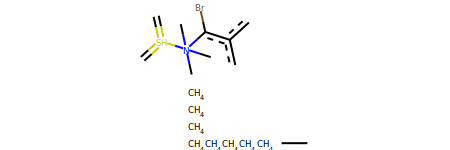

In [47]:
smiles = "C.C.C.C.C.C.C.C=S(=C)(=C)N(C)(C)(C)c(Br)c(c)c.CC"
smiles = "C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC"
from rdkit import Chem

from rdkit.Chem.Draw import IPythonConsole
Chem.MolFromSmiles(smiles, sanitize = False)

In [48]:
# Chem.MolFromSmiles("C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC")

In [49]:
smiles

'C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC'

In [50]:
bonds_labels

tensor([4, 4, 0,  ..., 4, 4, 4], device='cuda:0', grad_fn=<NotImplemented>)

In [51]:
dev_sym

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0])

In [52]:
mol = feat2smiles(SYMBOLS,None,BOND_TYPES,dev_sym, None, dev_bnd)

In [59]:
mol

'C.C.C.C.C.C.C.C.C.C1CCC1.C=C.CCCC.CCO'

# Validity

In [68]:
from molgen.metrics.mol_metrics import MolMetrics
metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False)

target = Y.get_graph_outputs()

In [83]:
metrics.batch_molecular_disconnected_validity(prediction, target)
metrics.batch_molecular_validity(prediction, target)
metrics.batch_symbol_accuracy(prediction, target)
metrics.batch_connected_components(prediction, target)
metrics.batch_invalid_valency_nodes(prediction, target)

100.0

In [80]:
feat2smiles()

TypeError: feat2smiles() missing 6 required positional arguments: 'SYMBOLS', 'FORMAL_CHARGES', 'BOND_TYPES', 'symbols', 'charges', and 'bonds'

In [70]:
target

array([{'SYMBOLS': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]), 'FORMAL_CHARGES': tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]), 'BOND_TYPES': tensor([[[0., 0., 0., 0., 1.],
 

In [207]:
molopt.ref

tensor([[-1.2517,  0.4915, -1.9540,  ..., -0.4416,  1.1475, -1.9537],
        [-0.2895,  0.4184,  0.2665,  ..., -2.4453, -0.5888,  0.2592],
        [-0.3932, -0.6139,  0.9896,  ..., -0.4043,  1.3791, -1.6461],
        ...,
        [ 1.2792,  0.6248, -1.1144,  ...,  0.5200,  0.0337, -0.4816],
        [-0.9822,  0.5073, -0.6295,  ..., -1.6160, -0.6144, -0.7320],
        [ 0.3101,  0.2944, -0.4003,  ..., -1.0795, -0.3007,  0.0121]],
       device='cuda:0', requires_grad=True)

In [57]:
ft = {
    "SYMBOLS" : SYMBOLS,
    "BOND_TYPES" : BOND_TYPES,
    "FORMAL_CHARGES" : FORMAL_CHARGES
}
Penalty(ft)

In [58]:
BOND_TYPES

[rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.DOUBLE,
 rdkit.Chem.rdchem.BondType.TRIPLE,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 None]

# Debug bonds

In [172]:
x_batch = Y
from mol_opt.ot_utils import compute_barycenter
import torch.nn.functional as F
from mol_opt.decoder_mol_opt import n_SYMBOLS, n_FORMAL_CHARGES, n_BOND_TYPES

In [166]:
molopt_decoder

MolOptDecoder(
  (fc1_SYMBOLS): Linear(in_features=50, out_features=150, bias=True)
  (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
  (fc1_CHARGES): Linear(in_features=50, out_features=150, bias=True)
  (fc2_CHARGES): Linear(in_features=150, out_features=5, bias=True)
  (fc1_BONDS): Linear(in_features=100, out_features=150, bias=True)
  (fc2_BONDS): Linear(in_features=150, out_features=5, bias=True)
)

In [182]:
bonds_logits = torch.empty(0, n_BOND_TYPES, device=args.device)
symbols_logits = torch.empty(0, n_SYMBOLS, device=args.device)
charges_logits = torch.empty(0, n_FORMAL_CHARGES, device=args.device)

for idx, (stx, lex) in enumerate(x_batch.scope):
    # x_narrow = x_embedding.narrow(0, stx, lex)
    x_narrow = yhat_embedding.narrow(0, idx*molopt_decoder.Nref, molopt_decoder.Nref)
    # cheating a bit here, by looking at what # of atoms should be
    x_narrow_resized = compute_barycenter(x_narrow, lex)

    symbols_logits_mol = molopt_decoder.fc2_SYMBOLS(F.relu(molopt_decoder.fc1_SYMBOLS(x_narrow_resized)))
    symbols_logits_mol = symbols_logits_mol.view(-1, n_SYMBOLS)
    symbols_logits = torch.cat((symbols_logits, symbols_logits_mol))

    charges_logits_mol = molopt_decoder.fc2_CHARGES(F.relu(molopt_decoder.fc1_CHARGES(x_narrow_resized)))
    charges_logits_mol = charges_logits_mol.view(-1, n_FORMAL_CHARGES)
    charges_logits = torch.cat((charges_logits, charges_logits_mol))

    x1 = x_narrow_resized.view(lex, 1, -1).repeat(1, lex, 1)
    x2 = x_narrow_resized.view(1, lex, -1).repeat(lex, 1, 1)
    _bonds = torch.cat((x1, x2), dim = 2)
    bonds_logits_mol = molopt_decoder.fc2_BONDS(F.relu(molopt_decoder.fc1_BONDS(_bonds)))
    break
    # add matrix with its transpose, to get the 
    bonds_logits_mol = bonds_logits_mol.view(lex, lex, n_BOND_TYPES) 
    bonds_logits_mol = bonds_logits_mol + bonds_logits_mol.permute(1,0,2) 
    bonds_logits_mol = bonds_logits_mol.view(-1, n_BOND_TYPES)
    bonds_logits = torch.cat((bonds_logits, bonds_logits_mol))
    
    break

In [197]:
bonds_logits_mol[:,:,0].unique()

tensor([-0.2525], device='cuda:0', grad_fn=<NotImplemented>)

In [200]:
_bonds[:,:,0]

tensor([[1.3135, 1.3135, 1.3135, 1.3135, 1.3135, 1.3135, 1.3135, 1.3135, 1.3135,
         1.3135, 1.3135, 1.3135, 1.3135, 1.3135, 1.3135, 1.3135, 1.3135, 1.3135,
         1.3135, 1.3135, 1.3135, 1.3135, 1.3135, 1.3135],
        [1.3257, 1.3257, 1.3257, 1.3257, 1.3257, 1.3257, 1.3257, 1.3257, 1.3257,
         1.3257, 1.3257, 1.3257, 1.3257, 1.3257, 1.3257, 1.3257, 1.3257, 1.3257,
         1.3257, 1.3257, 1.3257, 1.3257, 1.3257, 1.3257],
        [0.2607, 0.2607, 0.2607, 0.2607, 0.2607, 0.2607, 0.2607, 0.2607, 0.2607,
         0.2607, 0.2607, 0.2607, 0.2607, 0.2607, 0.2607, 0.2607, 0.2607, 0.2607,
         0.2607, 0.2607, 0.2607, 0.2607, 0.2607, 0.2607],
        [3.2451, 3.2451, 3.2451, 3.2451, 3.2451, 3.2451, 3.2451, 3.2451, 3.2451,
         3.2451, 3.2451, 3.2451, 3.2451, 3.2451, 3.2451, 3.2451, 3.2451, 3.2451,
         3.2451, 3.2451, 3.2451, 3.2451, 3.2451, 3.2451],
        [1.1173, 1.1173, 1.1173, 1.1173, 1.1173, 1.1173, 1.1173, 1.1173, 1.1173,
         1.1173, 1.1173, 1.1173, 1.1173

In [216]:
F.leaky_relu(molopt_decoder.fc1_BONDS(_bonds))

tensor([[[-0.0701, -0.0890, -0.5398,  ..., -0.0622, -0.0941, -0.2256],
         [-0.0677, -0.0891, -0.5351,  ..., -0.0630, -0.0944, -0.2176],
         [-0.0626, -0.0890, -0.4960,  ..., -0.0578, -0.0944, -0.1921],
         ...,
         [-0.0640, -0.0860, -0.5444,  ..., -0.0621, -0.0941, -0.2133],
         [-0.0671, -0.0907, -0.5255,  ..., -0.0618, -0.0912, -0.2163],
         [-0.0702, -0.0835, -0.4877,  ..., -0.0585, -0.0983, -0.2117]],

        [[-0.0683, -0.0875, -0.5327,  ..., -0.0630, -0.0923, -0.2169],
         [-0.0659, -0.0876, -0.5280,  ..., -0.0638, -0.0926, -0.2089],
         [-0.0608, -0.0876, -0.4889,  ..., -0.0587, -0.0926, -0.1834],
         ...,
         [-0.0622, -0.0845, -0.5374,  ..., -0.0630, -0.0922, -0.2046],
         [-0.0653, -0.0892, -0.5184,  ..., -0.0627, -0.0894, -0.2076],
         [-0.0685, -0.0820, -0.4806,  ..., -0.0594, -0.0965, -0.2030]],

        [[-0.0742, -0.0870, -0.4932,  ..., -0.0639, -0.0924, -0.1814],
         [-0.0718, -0.0870, -0.4885,  ..., -0

In [212]:
F.leaky_relu

<function torch.nn.functional.leaky_relu(input, negative_slope=0.01, inplace=False)>

In [209]:
list(molopt_decoder.fc1_BONDS.parameters())

[Parameter containing:
 tensor([[ 0.0212,  0.0551,  0.0952,  ..., -0.0505, -0.0010, -0.0275],
         [ 0.0026,  0.0151,  0.0127,  ...,  0.1711, -0.1787,  0.0684],
         [-0.2335,  0.3617, -0.1541,  ...,  0.6596,  0.0088,  0.5311],
         ...,
         [-0.0260, -0.0118, -0.0401,  ...,  0.0668, -0.0403,  0.1360],
         [-0.0839,  0.1181, -0.0512,  ..., -0.0442, -0.0875, -0.0311],
         [ 0.0871,  0.3638,  0.0892,  ...,  0.2207,  0.2458,  0.1275]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0444,  0.0014, -0.4464, -0.0447, -0.6545, -0.2617, -0.0996, -0.3990,
         -0.0043,  0.0018,  0.0261, -0.0301, -0.0837, -0.0293, -0.2843, -0.0361,
         -0.3253, -0.2612, -0.0728, -0.0763,  0.0193, -0.0442, -0.0263,  0.0269,
          0.0377, -0.0588, -0.3579, -0.6008, -0.0597, -0.3481, -0.4315, -0.1658,
         -0.5121, -0.1037, -0.1330, -0.5824, -0.1763, -0.0988, -0.4013, -0.3156,
         -0.0927, -0.2463, -0.1229, -0.3082, -0.0704,  0.0160,